In [1]:
import os
import random
import pandas as pd
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from Dataloader.SequenceExtractor import SequenceExtractor, collate_fn

2024-04-26 23:58:03.326955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
env_id = 'CarRacing-v2'
render_mode = "rgb_array"

env = DummyVecEnv([lambda: gym.make(env_id, render_mode=render_mode)])

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator().manual_seed(0)

In [4]:
# List all subfolders in the folder
models_subfolder = [f.path for f in os.scandir(env_id) if f.is_dir()]

# Choose a random subfolder
random_model_subfolder = random.choice(models_subfolder)

files = [f.path for f in os.scandir(random_model_subfolder) if f.is_file()]

random_file = random.choice(files)
random_file

'CarRacing-v2/model_11/seed_6839596180442651345.parquet'

In [5]:
# Read the Parquet file into a DataFrame
df = pd.read_parquet(random_file)
df['observation'] = df.apply(lambda row : row["observation"].reshape(env.observation_space.shape), axis = 1)
df

,observation,rewards,action
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",794.366150,"[0.15016586, 0.21998379, 0.0]"
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",787.423950,"[-0.9121764, 1.0, 0.0]"
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",787.523926,"[-0.72859955, 1.0, 0.0]"
3,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",787.623901,"[-0.53236175, 0.0, 0.0]"
4,"[[[100, 224, 100], [100, 202, 100], [100, 202,...",787.723877,"[-0.53121686, 0.6943532, 0.0]"
...,...,...,...
995,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.500000,"[0.73074234, 0.0, 0.0]"
996,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.400000,"[-0.89041084, 0.6645784, 0.0]"
997,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.300000,"[-1.0, 0.0, 0.0]"
998,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.200000,"[0.008062333, 0.5789722, 0.0]"


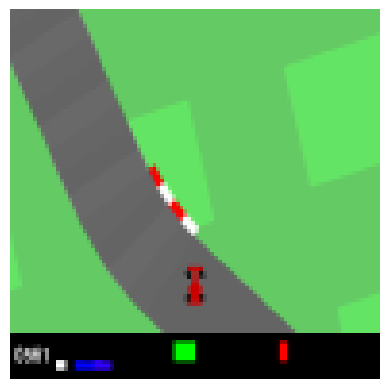

(232.94226, array([-1.        ,  0.24569435,  0.        ], dtype=float32))

In [6]:
random_row = random.randint(0, len(df))
plt.imshow(df["observation"][random_row])
plt.axis('off')  # Turn off axis labels
plt.show()
df["rewards"][random_row], df["action"][random_row]

In [7]:
sequenceExtractorTrain = SequenceExtractor(env, dataset_len = 128)

In [8]:
batch_size = 128
dataloader_train = DataLoader(sequenceExtractorTrain, batch_size=batch_size, 
                        shuffle=True, num_workers=1, collate_fn = collate_fn,
                        worker_init_fn=seed_worker, generator=g)

torch.Size([128, 32, 1]) torch.Size([128, 32, 3, 96, 96]) torch.Size([128, 32, 3])


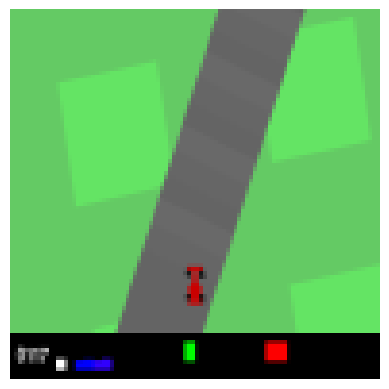

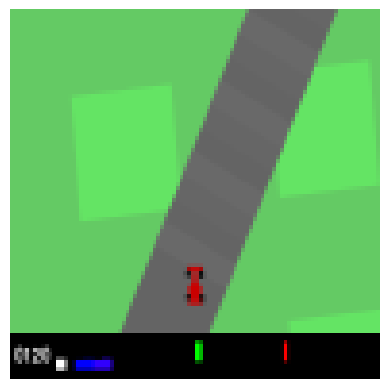

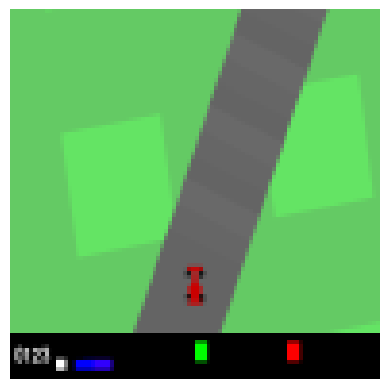

tensor([0.6883]) tensor(0.9922) tensor([0.6378, 0.3072, 0.0000])


In [9]:
for batch in dataloader_train:
    X, y = batch
    
    rewards = X["rewards"]
    observations = X["observations"]
    actions = X["actions"]
    
    print(rewards.shape, observations.shape, actions.shape )

    plt.imshow(observations[0][0].permute(1, 2, 0))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    plt.imshow(observations[0][3].permute(1, 2, 0))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    plt.imshow(observations[0][6].permute(1, 2, 0))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    print(rewards[0][0],observations.max(), actions[0][0])